In [17]:
%load_ext autoreload
%autoreload 2

In [75]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import utils
import eval

from model.stgcn import stgcn
from model.st_graph import get_distance_adjacency
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

In [19]:
edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

# Load the Le2i Coffe Room and Home

In [20]:
# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'offset', 'fall_interval'])
coffee_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\falls.npy", allow_pickle=True)
coffee_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\non_falls.npy", allow_pickle=True)
home_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\falls.npy", allow_pickle=True)
home_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\non_falls.npy", allow_pickle=True)

In [124]:
c_fall_train, c_fall_test = train_test_split(coffee_falls, test_size=0.2, random_state=217)
c_nfall_train, c_nfall_test = train_test_split(coffee_non_falls, test_size=0.2, random_state=217)
h_fall_train, h_fall_test = train_test_split(home_falls, test_size=0.2, random_state=217)
h_nfall_train, h_nfall_test = train_test_split(home_non_falls, test_size=0.2, random_state=217)

c_test = [('coffee_room ' + data['filename'], data['keypoints']) for data in c_fall_test.tolist()] + [('coffee_room ' + data['filename'], data['keypoints']) for data in c_nfall_test.tolist()]
h_test = [('home ' + data['filename'], data['keypoints']) for data in h_fall_test.tolist()] + [('home ' + data['filename'], data['keypoints']) for data in h_nfall_test.tolist()]
test_data = c_test + h_test
test_labels = np.concatenate((np.ones(len(c_fall_test)), np.zeros(len(c_nfall_test)), np.ones(len(h_fall_test)), np.zeros(len(h_nfall_test))))

In [49]:
falls = []
non_falls = []

train_falls, train_non_falls = utils.split_skeletons(c_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(c_nfall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_fall_train)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(h_nfall_train)
falls += train_falls
non_falls += train_non_falls

falls = np.array(falls)
non_falls = np.array(non_falls)

X_falls = falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

print(X_falls.shape, X_non_falls.shape)

(78, 45, 17, 2) (689, 45, 17, 2)


In [50]:
# normalize the data using the max values in the dataset
# the original coordinates is stored as (x, y)
# Le2i resolution is 320x240

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
print(X_falls.shape, X_non_falls.shape)

(78, 2, 45, 17) (689, 2, 45, 17)


# Initialize the model and dataset object

In [52]:
num_node = 17
A = get_distance_adjacency(np.array(edges), num_node)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [54]:
class FallDataset(Dataset):
    def __init__(self, falls, non_falls):
        self.falls = falls
        self.non_falls = non_falls

    def __len__(self):
        # The dataset length is twice the length of the smaller list
        return len(self.falls) + len(self.non_falls)

    def __getitem__(self, idx):
        if idx < len(self.falls):
            return self.falls[idx], 1.0
        else:
            return self.non_falls[idx - len(self.falls)], 0.0

class BalancedBatchSampler(Sampler):
    def __init__(self, dataset):
        self.num_falls = len(dataset.falls)
        self.num_non_falls = len(dataset.non_falls)
        self.data_size = self.num_falls + self.num_non_falls
        self.batch_size = 2 * self.num_falls

    def __iter__(self):
        # Create an array of indices representing balanced classes
        non_fall_indices = np.arange(self.num_non_falls)
        np.random.shuffle(non_fall_indices)  # Shuffle the indices to have random batches
        batch = np.arange(self.num_falls).tolist()
        for idx in non_fall_indices:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = np.arange(self.num_falls).tolist()
        if len(batch) > 0:  # Yield remaining items not fitting into a full batch
            yield batch

    def __len__(self):
        return (self.data_size + self.batch_size - 1) // self.batch_size

def evaluate(model, loader, print_acc=False):
    model.eval()
    loss_func = nn.CrossEntropyLoss()
    acc, loss = 0.0, 0.0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)
        with torch.no_grad():
            y_pred = model(X_batch)
            loss += loss_func(y_pred, y_batch).detach().cpu().item()
            acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()
            
    loss /= len(loader.dataset)
    acc /= len(loader.dataset)
    return loss, acc

In [55]:
falls_train, falls_valid = train_test_split(X_falls, test_size=0.2, random_state=217)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid), random_state=217)
training_set = FallDataset(falls=falls_train, non_falls=non_falls_train)
validation_set = FallDataset(falls=falls_valid, non_falls=non_falls_valid)

In [56]:
training_loader = DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = DataLoader(validation_set, batch_size=100, shuffle=False)

In [62]:
layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
model = None
model = stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config)
model.to(device)

stgcn(
  (stgcn_in): Sequential(
    (0): unit_sgcn(
      (conv_nets): ModuleList(
        (0-1): 2 x Conv2d(2, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
    (1): unit_tgcn(
      (conv_net): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (non_linearity): ReLU()
    )
  )
  (layers): ModuleList(
    (0-2): 3 x stgcn_unit(
      (sgcn): unit_sgcn(
        (conv_nets): ModuleList(
          (0-1): 2 x Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (non_linearity): ReLU()
      )
      (tgcn): unit_tgcn(
        (conv_net): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (bn): BatchNorm2d(64, eps=1e-05, 

# Training loop

Training Loss: 0.0040: 100%|██████████| 25/25 [00:44<00:00,  1.78s/it]


Training loss: 0.004011996911496532
Validation loss: 0.012877593748271465
Training accuracy: 0.9414965986394558
Validation accuracy: 0.90625


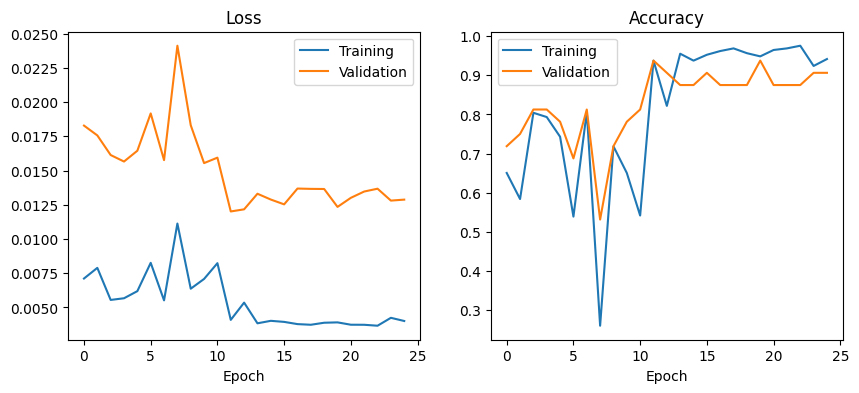

In [63]:
epochs = 25
lr = 0.001
weight_decay = 0
batch_size = 100
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
train_eval_loader = torch.utils.data.DataLoader(training_set, batch_size=100, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch)
        batch_loss = loss_func(y_pred, y_batch)

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    
    # scheduler.step()

    train_loss, train_acc = evaluate(model, train_eval_loader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

In [143]:
acc, results = eval.evaluate(model, device, testset=(test_data, test_labels), profile=True)

100%|██████████| 28/28 [00:03<00:00,  8.34it/s]

False positives: []
False negatives: []
Accuracy: 1.0


In [144]:
results[1][3]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9998, 0.9952, 0.8285, 0.9201, 0.9989, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [79]:
torch.save(model.state_dict(), 'le2i_90acc_default.pth')

# Test on unseen data

In [103]:
LEC_ROOM_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Skeletons_full"
OFFICE_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Skeletons_full"

lec_room = eval.load_data(LEC_ROOM_DIR)
lec_room = [('lec_room ' + data[0], data[1]) for data in lec_room]
    
office = eval.load_data(OFFICE_DIR)
office = [('office ' + data[0], data[1]) for data in office]

In [170]:
lec_room_acc, lec_room_results = eval.evaluate(model, device, testset=(lec_room, eval.LEC_ROOM_LABELS), profile=True)
office_acc, office_results = eval.evaluate(model, device, testset=(office, eval.OFFICE_LABELS), profile=True)

100%|██████████| 27/27 [00:05<00:00,  4.82it/s]


False positives: ['lec_room video (15)', 'lec_room video (16)', 'lec_room video (17)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21)', 'lec_room video (22)', 'lec_room video (23)', 'lec_room video (24)', 'lec_room video (25)', 'lec_room video (26)', 'lec_room video (27)']
False negatives: []
Accuracy: 0.5555555555555556


100%|██████████| 33/33 [00:05<00:00,  6.15it/s]

False positives: ['office video (19)', 'office video (25)']
False negatives: ['office video (11)']
Accuracy: 0.9090909090909091


In [171]:
lec_room_results[18]

('lec_room video (19)',
 0,
 1,
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [172]:
lec_room_results[17][4]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9999, 0.9998, 0.9996, 0.9993, 0.9990, 0.9985, 0.9982,
        0.9982, 0.9983, 0.9987, 0.9990, 0.9992, 0.9995, 0.9997, 0.9997, 0.9997,
        0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9999, 0.9999, 0.9999, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 